# Tau protein segmentation using CNN

- The goal of this notebook is to demonstrate who to use a *convolutional neural network* to segment Tau protein - a protein related to Alzheimer's development, in human brain digital pathology images. 
- This is part of a bigger project for creating 3d quantitative map of Tau protein, aiming at validating neuroimaging data and searching for better Alzheimer's biomarkers.
- Challenge: each image spans several Gigabytes, while an entire brain can spam 800+ images
- The entire image processing for this project comprises several imaging, pre-processing and registration steps, but I will focus in the core segmentation step, where the proteins are automatically segmented.


### Preprint: https://www.biorxiv.org/content/10.1101/698902v2

![title](img/Deep_Learning_Fig1_red.png)

### Custom-made scanner designed to image whole brain slides:
Java source-code: https://github.com/mary-alegro/LargeSlideScan

<img src="img/scanner.png" width="500"/>

- That's how one of my images look like. The tiny blobs in the zoomed image are Tau protein inclusions I'm looking for. 
- CNNs are great for this task since they are very robust to artifacts.

![title](img/slide.png)

This notebook is divided in two parts:
- Tau segmentation using a convolutional neural network
- Network validation

# 1.Tau segmentation using a convolutional neural network

In [1]:
import sys
sys.path.append('src/')

import configparser as cparser
from keras.models import model_from_json
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, UpSampling2D, Reshape, core, Dropout, Cropping2D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard
from keras import backend as K
from keras.activations import linear
import tensorflow as tf
from tensorflow.python.framework import ops
from keras.utils.vis_utils import plot_model
from keras.optimizers import SGD
import numpy as np

#set random seed
from numpy.random import seed
seed(17)
from tensorflow import set_random_seed
set_random_seed(17)

from convnet.util.help_functions import *
from convnet.util.extract_patches import recompone_overlap, get_data_segmenting_overlap
from convnet.util.scores import *
from convnet.net.TauImageGenerator import TauImageGenerator
from convnet.util.lr_finder import LRFinder

import fnmatch
from misc.imoverlay import imoverlay as imoverlay
import mahotas as mh
from mahotas import bwperim

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
import cv2
from sklearn.metrics import auc

import glob
import skimage.io as io
from skimage import img_as_ubyte

import time
import os
#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
#os.environ["CUDA_VISIBLE_DEVICES"]="1"

/Users/maryana/bin/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/Users/maryana/bin/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/maryana/bin/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/maryana/bin/anaconda3/

# Network architecture and training

![title](img/Slidenet.png)

- Manually designed to work with 1mm^2 of tissue from our images
- Works with RGB data

Neural network architecture in Keras:

In [2]:
class SlidenetFactory:

    def get_model(self,name, *args):
        return  self._get_network(name,*args)


    def _get_network(self, name, *args):
        if name == 'slidenet2':
            return self._get_slidenet(*args)
        else:
            raise ValueError(name)

    # Define the neural network
    def _get_slidenet(self,n_ch=3,patch_height=204,patch_width=204,lr_rate=0.005):
        inputs = Input(shape=(n_ch, patch_height, patch_width))
        conv1 = Conv2D(32, (3, 3), activation='relu', data_format='channels_first')(inputs)
        conv1 = Conv2D(32, (3, 3), activation='relu', data_format='channels_first')(conv1)
        pool1 = MaxPooling2D((2, 2))(conv1)
        pool1 = Dropout(0.1)(pool1)

        conv2 = Conv2D(64, (3, 3), activation='relu', data_format='channels_first')(pool1)
        conv2 = Conv2D(64, (3, 3), activation='relu', data_format='channels_first')(conv2)
        pool2 = MaxPooling2D((2, 2))(conv2)
        pool2 = Dropout(0.1)(pool2)

        conv3 = Conv2D(128, (3, 3), activation='relu', data_format='channels_first')(pool2)
        conv3 = Conv2D(128, (3, 3), activation='relu', data_format='channels_first')(conv3)
        pool3 = MaxPooling2D((2, 2))(conv3)
        pool3 = Dropout(0.1)(pool3)

        conv4 = Conv2D(256, (1, 1), activation='relu', data_format='channels_first')(pool3)
        conv4 = Conv2D(256, (1, 1), activation='relu', data_format='channels_first')(conv4)
        up4 = UpSampling2D(size=(2, 2))(conv4)
        up4 = concatenate([conv3, up4], axis=1)
        up4 = Dropout(0.1)(up4)

        conv5 = Conv2D(128, (3, 3), activation='relu', data_format='channels_first')(up4)
        conv5 = Conv2D(128, (3, 3), activation='relu', data_format='channels_first')(conv5)
        up5 = UpSampling2D(size=(2, 2))(conv5)
        crop_conv6 = Cropping2D(cropping=((8, 8), (8, 8)))(conv2)
        up6 = concatenate([crop_conv6, up5], axis=1)
        up6 = Dropout(0.1)(up6)

        conv6 = Conv2D(64, (3, 3), activation='relu', data_format='channels_first')(up6)
        conv6 = Conv2D(64, (3, 3), activation='relu', data_format='channels_first')(conv6)
        up7 = UpSampling2D(size=(3, 3))(conv6)
        crop_conv7 = Cropping2D(cropping=((14, 14), (14, 14)))(up7)
        up7 = concatenate([conv1, crop_conv7], axis=1)
        up7 = Dropout(0.1)(up7)

        conv7 = Conv2D(32, (1, 1), activation='relu', data_format='channels_first')(up7)
        conv7 = Conv2D(2, (1, 1), activation='relu', data_format='channels_first')(conv7)
        conv7 = Dropout(0.1)(conv7)

        conv7 = core.Reshape((2, 200 * 200))(conv7)
        conv7 = core.Permute((2, 1))(conv7)
        softmax = core.Activation('softmax')(conv7)
        #softmax = core.Activation('sigmoid')(conv7)
        model = Model(input=inputs, output=softmax)

        adam = Adam(lr=lr_rate)
        model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'], sample_weight_mode='temporal')

        model.summary()

        return model

Example of image/label pair:

In [7]:
!ls db_validation

mask


/Users/maryana/bin/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from uint16 to uint8
  .format(dtypeobj_in, dtypeobj_out))


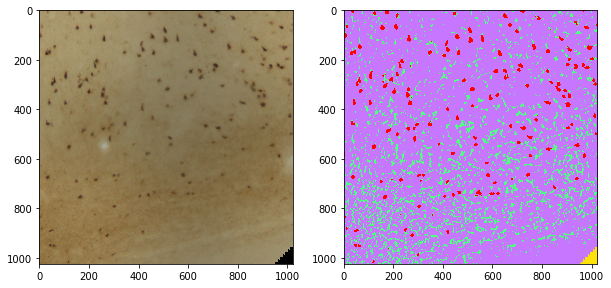

In [3]:
test_img = io.imread('results/validation/heat_map/seg_tiles/patch_82790378-6d05-11e9-81c1-484d7ede57b2.tif')
gt_img = io.imread('db_validation/masks/patch_82790378-6d05-11e9-81c1-484d7ede57b2_mask.tif')
gt_img = img_as_ubyte(gt_img)

fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(test_img)
ax2 = fig.add_subplot(1,2,2)
ax2.imshow(gt_img)
plt.show()

### 3 datasets: training (80% data), testing (10% data) and validation (10% data)

Declare the class responsible for training the network. Note that this class also implements the code for using _cyclic learning rate_ to find the best learning rate.

In [4]:
class NetworkTrainer:

    def __init__(self,config_file):
        config = cparser.RawConfigParser()
        config.read(config_file)

        # Experiment name
        self.name_experiment = config.get('experiment name', 'name')

        # training settings
        self.N_epochs = int(config.get('training settings', 'N_epochs'))
        self.batch_size = int(config.get('training settings', 'batch_size'))
        self.path_project = config.get('data paths', 'path_project')
        self.path_model = os.path.join(self.path_project, config.get('data paths', 'path_model'))
        self.n_ch = int(config.get('data attributes', 'num_channels'))
        self.patch_height = int(config.get('data attributes', 'patch_height'))
        self.patch_width = int(config.get('data attributes', 'patch_width'))
        self.img_dim = (self.patch_height, self.patch_width, self.n_ch)
        self.nClasses = int(config.get('data attributes', 'num_classes'))
        self.mask_height = int(config.get('data attributes', 'mask_height'))
        self.mask_width = int(config.get('data attributes', 'mask_width'))
        self.mask_dim = (self.mask_height,self.mask_width)

        # relevant paths
        self.train_imgs_dir = os.path.join(self.path_project, config.get('data paths', 'train_imgs_original'))
        self.train_masks_dir = os.path.join(self.path_project, config.get('data paths', 'train_groundTruth'))
        self.test_imgs_dir = os.path.join(self.path_project, config.get('data paths', 'test_imgs_original'))
        self.test_masks_dir = os.path.join(self.path_project, config.get('data paths', 'test_groundTruth'))
        self.mean_img_path = os.path.join(self.path_project, config.get('data paths', 'mean_image'))
        self.train_log = os.path.join(self.path_project, config.get('data paths', 'train_log'))

        #get network model
        self.net_name = config.get('experiment name','network')


    def run_training(self,l_rate):
        #instantiate network model
        cnn_factory = SlidenetFactory()
        model = cnn_factory.get_model(self.net_name,self.n_ch, self.patch_height, self.patch_width, l_rate)

        print("Check: final output of the network:")
        print(model.output_shape)
        json_string = model.to_json()

        model_file = os.path.join(self.path_model, self.name_experiment + '_architecture.json')
        best_weights_file = os.path.join(self.path_model, self.name_experiment + 'weights_{epoch:03d}_{val_loss:.4f}.h5')
        last_weights_files = os.path.join(self.path_model, self.name_experiment + '_last_weights.h5')

        open(model_file, 'w').write(json_string)

        # Keras callbacks
        checkpointer = ModelCheckpoint(filepath=best_weights_file, verbose=1, monitor='val_loss', mode='auto',
                                       save_best_only=False)  # save at each epoch if the validation decreases
        tensorboard = TensorBoard(log_dir=self.train_log, histogram_freq=0, batch_size=self.batch_size, write_graph=True,
                                  write_grads=False,
                                  write_images=False, embeddings_freq=0, embeddings_layer_names=None,
                                  embeddings_metadata=None)

        # instatiate image generators
        train_gen = TauImageGenerator('train_gen', self.train_imgs_dir, self.train_masks_dir, self.mean_img_path,
                                      self.img_dim, self.mask_dim, self.nClasses, self.batch_size,
                                      do_augmentation=True, augment_percent=0.40)
        test_gen = TauImageGenerator('test_gen', self.test_imgs_dir, self.test_masks_dir, self.mean_img_path,
                                     self.img_dim, self.mask_dim, self.nClasses, self.batch_size,
                                     do_augmentation=False, augment_percent=0.40)
        # fit model
        model.fit_generator(generator=train_gen.get_batch(),
                            validation_data=test_gen.get_batch(),
                            steps_per_epoch=train_gen.__len__(),
                            validation_steps=test_gen.__len__(),
                            epochs=self.N_epochs,
                            verbose=1,
                            callbacks=[checkpointer, tensorboard])

        # save last weights
        model.save_weights(last_weights_files, overwrite=True)

    ## use the image generators to create image batches 
    def get_data_lr(self,nBatches):

        tau_gen = TauImageGenerator('find_lr_gen', self.train_imgs_dir, self.train_masks_dir, self.mean_img_path,
                                    self.img_dim, self.mask_dim, self.nClasses, self.batch_size, do_augmentation=True,
                                    augment_percent=0.50)
        batch_gen = tau_gen.get_batch()

        X_train = []  # images
        Y_train = []  # masks
        for i in range(nBatches):
            x, y = next(batch_gen)
            if X_train == []:
                X_train = x
            else:
                X_train = np.concatenate((X_train, x), axis=0)
            if Y_train == []:
                Y_train = y
            else:
                Y_train = np.concatenate((Y_train, y), axis=0)
        return X_train, Y_train

    # cyclic learning rate
    def run_find_lr(self):
        cnn_factory = SlidenetFactory()
        model = cnn_factory.get_model(self.net_name,self.n_ch, self.patch_height, self.patch_width)

        print('Creating dataset.')
        nBatches_ds = 20
        img_train, mask_train = self.get_data_lr(nBatches_ds)

        lr_finder = LRFinder(min_lr=1e-6,
                             max_lr=1e-1,
                             steps_per_epoch=np.ceil(img_train.shape[0] / float(nBatches_ds)),
                             epochs=nBatches_ds*2)
        model.fit(img_train, mask_train, callbacks=[lr_finder], epochs=nBatches_ds*2)

        lr_finder.plot_loss()

In [5]:
#%psource TauImageGenerator

Run _cyclic learning rate_ to estimate best lr:

In [ ]:
# config_path = 'configuration.txt'
# cnn_trainer = NetworkTrainer(config_path)
# cnn_trainer.run_find_lr()

<img src="img/clr.png" width="600"/>

Run training:

In [ ]:
# l_rate = 0.004
# cnn_trainer.run_training(l_rate)

<img src="img/training_graphs.png" width="700"/>

# Image segmentation

Create the function responsible for iterating over _rootdir_ subfolders, find the images and run the segmentation:

In [5]:
class Segmentation:

    def __init__(self, config_file):
        self.TISSUE_THRESH = 0.05

        # read config
        config = cparser.RawConfigParser()
        config.read(config_file)
        path_project = config.get('data paths', 'path_project')
        path_model = os.path.join(path_project, config.get('data paths', 'path_model'))

        # dimension of the patches
        self.patch_height = int(config.get('data attributes', 'patch_height'))
        self.patch_width = int(config.get('data attributes', 'patch_width'))
        self.mask_height = int(config.get('data attributes', 'mask_height'))
        self.mask_width = int(config.get('data attributes', 'mask_width'))
        self.mask_dim = (self.mask_height, self.mask_width)
        self.imgs_to_test = int(config.get('testing settings', 'full_images_to_test')),

        # model name
        self.name_experiment = config.get('experiment name', 'name')
        self.average_mode = config.getboolean('testing settings', 'average_mode')
        self.stride_height = int(config.get('testing settings', 'stride_height'))
        self.stride_width = int(config.get('testing settings', 'stride_width'))

        # load mean image for pre-processing
        self.mean_img_path = os.path.join(path_project, config.get('data paths', 'mean_image'))

        # Load the saved model
        self.model = model_from_json(open(os.path.join(path_model, self.name_experiment + '_architecture.json')).read())
        self.model.load_weights(os.path.join(path_model, self.name_experiment + '_best_weights.h5'))


    # count the number of non-background pixels
    def get_num_pix_tissue(self, img):  # assumes RGB image
        tmp_img = img[:, :, 0] + img[:, :, 1] + img[:, :, 2]
        tmp_nnz_b = tmp_img.flatten().nonzero()
        nnz_b = float(len(tmp_nnz_b[0]))  # number of non-zero pixel in img
        return nnz_b

    # get folders inside _root_dir_
    def get_folder_list(self, root_dir):
        folder_list = []

        for root, dir, files in os.walk(root_dir):
            if fnmatch.fnmatch(root, '*heat_map'):
                folder_list.append(root)

        return folder_list
    
    
    #
    # Segmentation directory structure:
    # root_dir
    #    |
    #    -img1
    #       |
    #       - heat_map
    #             |
    #             - seg_tiles   <-- images to be segmented
    #             - TAU_seg_tiles   <-- segmentation results
    #     ...
    #     | 
    #     -imgN
    #       |
    #       - heat_map
    #             |
    #             - seg_tiles
    #             - TAU_seg_tiles

    def run_segmentation(self, root_dir):
        nError = 0

        dir_list = self.get_folder_list(root_dir)
        for folder in dir_list:

            # check if tiles folder exists
            tiles_dir = os.path.join(folder, 'seg_tiles')
            if not os.path.exists(tiles_dir):
                print('Error: tiles folder {} does not exist.'.format(tiles_dir))
                continue

            # create output folder
            out_dir = os.path.join(folder, 'TAU_seg_tiles')
            if not os.path.exists(out_dir):
                os.mkdir(out_dir)

            print('*** Processing files in folder {}'.format(folder))

            # get a list of tif files
            files = glob.glob(os.path.join(tiles_dir, '*.tif'))
            nTotal = len(files)
            print('### {} tile(s) to segment.### '.format(nTotal))

            for fname in files:
                basename = os.path.basename(fname)
                out_name_seg = os.path.join(out_dir, basename[0:-4] + '_mask.tif')
                out_name_prob = os.path.join(out_dir, basename[0:-4] + '_prob.npy')

                test_imgs_original = os.path.join(tiles_dir, basename)
                print('Segmenting image {}.'.format(test_imgs_original))

                # Load the data and divide in patches
                try:
                    # load image to segment
                    orig_img = io.imread(test_imgs_original)
                except:
                    nError += 1
                    print("Error opening file {}".format(test_imgs_original))
                    continue

                # check if image has enough tissue
                npix_tissue = self.get_num_pix_tissue(orig_img)
                percent_tissue = npix_tissue / (orig_img.shape[0] * orig_img.shape[1])
                if percent_tissue < self.TISSUE_THRESH:
                    print('Image has too little tissue. Skipping.')
                    continue

                # pad sides
                orig_img_pad = pad_image(orig_img.copy(), self.patch_height, self.patch_width)

                # original tiles are 1024x1024
                # break image into smaller patches of 204x204 (network input size)
                patches_imgs_test, new_height, new_width, masks_test = get_data_segmenting_overlap(
                    test_img_original = orig_img_pad.astype('float'),  # image path to segment
                    Imgs_to_test = self.imgs_to_test,
                    mean_image_path = self.mean_img_path,
                    patch_height = self.patch_height,
                    patch_width = self.patch_width,
                    stride_height = self.stride_height,
                    stride_width = self.stride_width,
                    is_color = True
                )

                # calculate the predictions
                start = time.clock()
                predictions = self.model.predict(patches_imgs_test, batch_size=32, verbose=2)
                end = time.clock()
                print("**Time per image: {} ".format((end - start) / 32))
                print("predicted images size :")
                print(predictions.shape)

                # convert the prediction arrays in corresponding images
                pred_patches = pred_to_imgs(predictions, self.mask_dim[0], self.mask_dim[1], "original")

                new_pred_patches = np.zeros((pred_patches.shape[0], 1, self.patch_height, self.patch_width))
                nP = pred_patches.shape[0]

                # network output is 200x200, resize to original dimensions
                for p in range(nP):
                    tmp = pred_patches[p, 0, ...]
                    tmp = cv2.resize(tmp, (self.patch_height,self. patch_width), interpolation=cv2.INTER_NEAREST)
                    new_pred_patches[p, 0, ...] = tmp


                pred_imgs = recompone_overlap(new_pred_patches, new_height, new_width, self.stride_height,
                                                  self.stride_width)  # predictions
                img = pred_imgs[0, 0, ...]  # get matrix for Tau prediction

                # remove padding 1
                pad_r1 = new_height - orig_img_pad.shape[0]
                pad_c1 = new_width - orig_img_pad.shape[1]
                img = img[0:img.shape[0] - pad_r1, 0:img.shape[1] - pad_c1, ...]

                # remove padding 2
                img = img[self.patch_height:img.shape[0] - self.patch_height, self.patch_width:img.shape[1] - self.patch_width, ...]

                # threshold
                mask = img > 0.7  # threshold class probabilities

                print('Saving probability file {}'.format(out_name_prob))
                np.save(out_name_prob, img)

                # mask out background just in case
                mask_bkg = orig_img[..., 0] < 1.
                mask[mask_bkg == True] = False

                print('Saving {}'.format(out_name_seg))
                io.imsave(out_name_seg, (mask * 255).astype('uint8'))

            print("Segmentation ended with {} errors".format(nError))



Run segmentation:

In [6]:
root_dir = 'results'
config_file = 'configuration.txt'

segmentation = Segmentation(config_file)
segmentation.run_segmentation(root_dir)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
*** Processing files in folder results/testing/heat_map
### 3 tile(s) to segment.### 
Segmenting image results/testing/heat_map/seg_tiles/patch_77f99f4a-6d05-11e9-81c1-484d7ede57b2.tif.

the side H is not compatible with the selected stride of 90
img_h 1432, patch_h 204, stride_h 90
(img_h - patch_h) MOD stride_h: 58
So the H dim will be padded with additional 32 pixels
the side W is not compatible with the selected stride of 90
img_w 1432, patch_w 204, stride_w 90
(img_w - patch_w) MOD stride_w: 58
So the W dim will be padded with additional 32 pixels
new full images shape: 
(1, 3, 1464, 1464)
Number of patches on h : 15
Number of patches on w : 15
number of patches per image: 225, totally for this dataset: 225
**Time per image: 5.976011625 
predicted images size :
(225, 40000, 2)
(1, 1, 1464, 1464)
S

In [7]:
!ls -lah results/validation/heat_map/TAU_seg_tiles/

total 55344
drwxr-xr-x  8 maryana  staff   256B Nov 21 20:49 .
drwxr-xr-x  4 maryana  staff   128B Nov 21 20:49 ..
-rw-r--r--  1 maryana  staff   1.0M Nov 21 21:35 patch_82790378-6d05-11e9-81c1-484d7ede57b2_mask.tif
-rw-r--r--  1 maryana  staff   8.0M Nov 21 21:35 patch_82790378-6d05-11e9-81c1-484d7ede57b2_prob.npy
-rw-r--r--  1 maryana  staff   1.0M Nov 21 21:34 patch_c45a744a-6d05-11e9-81c1-484d7ede57b2_mask.tif
-rw-r--r--  1 maryana  staff   8.0M Nov 21 21:34 patch_c45a744a-6d05-11e9-81c1-484d7ede57b2_prob.npy
-rw-r--r--  1 maryana  staff   1.0M Nov 21 21:33 patch_c45a744b-6d05-11e9-81c1-484d7ede57b2_mask.tif
-rw-r--r--  1 maryana  staff   8.0M Nov 21 21:33 patch_c45a744b-6d05-11e9-81c1-484d7ede57b2_prob.npy


In [8]:
!ls -lah results/testing/heat_map/TAU_seg_tiles/

total 55344
drwxr-xr-x  8 maryana  staff   256B Nov 21 20:49 .
drwxr-xr-x  4 maryana  staff   128B Nov 21 20:49 ..
-rw-r--r--  1 maryana  staff   1.0M Nov 21 21:30 patch_77f99f4a-6d05-11e9-81c1-484d7ede57b2_mask.tif
-rw-r--r--  1 maryana  staff   8.0M Nov 21 21:30 patch_77f99f4a-6d05-11e9-81c1-484d7ede57b2_prob.npy
-rw-r--r--  1 maryana  staff   1.0M Nov 21 21:32 patch_a6da76aa-6d05-11e9-81c1-484d7ede57b2_mask.tif
-rw-r--r--  1 maryana  staff   8.0M Nov 21 21:32 patch_a6da76aa-6d05-11e9-81c1-484d7ede57b2_prob.npy
-rw-r--r--  1 maryana  staff   1.0M Nov 21 21:31 patch_a6da76af-6d05-11e9-81c1-484d7ede57b2_mask.tif
-rw-r--r--  1 maryana  staff   8.0M Nov 21 21:31 patch_a6da76af-6d05-11e9-81c1-484d7ede57b2_prob.npy


Visualize segmentation example from validation dataset:

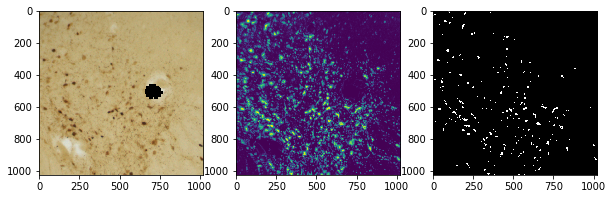

In [9]:
test_img = io.imread('results/validation/heat_map/seg_tiles/patch_c45a744b-6d05-11e9-81c1-484d7ede57b2.tif')
test_seg = io.imread('results/validation/heat_map/TAU_seg_tiles/patch_c45a744b-6d05-11e9-81c1-484d7ede57b2_mask.tif')
test_prob = np.load('results/validation/heat_map/TAU_seg_tiles/patch_c45a744b-6d05-11e9-81c1-484d7ede57b2_prob.npy')

fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1,3,1)
ax1.imshow(test_img)
ax2 = fig.add_subplot(1,3,2)
ax2.imshow(test_prob)
ax3 = fig.add_subplot(1,3,3)
ax3.imshow(test_seg, cmap='gray')
plt.show()

Segmentation overlaid on original image:

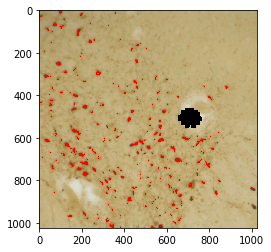

In [10]:
overlay = imoverlay(test_img,test_seg,[1,0,0])
plt.imshow(overlay)
plt.show()

# 2. Network validation

Example of image and manual label pair:

/Users/maryana/bin/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from uint16 to uint8
  .format(dtypeobj_in, dtypeobj_out))


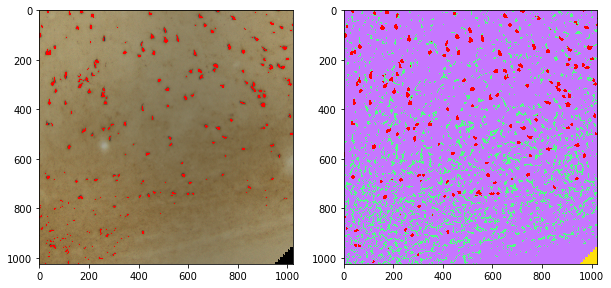

In [11]:
test_img = io.imread('results/validation/heat_map/seg_tiles/patch_82790378-6d05-11e9-81c1-484d7ede57b2.tif')
test_seg = io.imread('results/validation/heat_map/TAU_seg_tiles/patch_82790378-6d05-11e9-81c1-484d7ede57b2_mask.tif')
gt_img = io.imread('db_validation/masks/patch_82790378-6d05-11e9-81c1-484d7ede57b2_mask.tif')
gt_img = img_as_ubyte(gt_img)

overlay = imoverlay(test_img,test_seg,[1,0,0])

fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(overlay)
ax2 = fig.add_subplot(1,2,2)
ax2.imshow(gt_img)
plt.show()

## Plot ROC and Precision-Recall curves

Class that implements functions for computing network scores:

In [12]:
class Scores:

    # convert color-coded label to binary mask
    def _convert_mask2binary(self,g_truth):
        # process mask
        g_truth = img_as_ubyte(g_truth)
        mask_bkg = g_truth[..., 2] == 10
        mask_gm = g_truth[..., 2] == 255
        mask_thread = g_truth[..., 2] == 130
        mask_cell = g_truth[..., 2] == 0

        mask_fore = (mask_cell | mask_thread) * 255
        mask_bkg = (mask_gm | mask_bkg) * 255  # black background and GM together
        mask_fore_bin = mask_fore >= 255
        mask_back_bin = mask_bkg >= 255

        mask = np.concatenate((mask_fore_bin[..., np.newaxis], mask_back_bin[..., np.newaxis]), axis=2)

        return mask

    # get image/label pairs
    def _get_file_pairs(self,seg_dir, mask_dir):
        file_map = {}
        seg_list = glob.glob(os.path.join(seg_dir, '*.npy'))
        for prob_file in seg_list:
            basename = os.path.basename(prob_file)
            parcname = basename[:-9]
            mask_name = parcname + '_mask.tif'  # ground truth mask, not segmented mask
            mask_name = os.path.join(mask_dir, mask_name)

            file_map[prob_file] = mask_name

        return file_map

    # compute a set of scores based on the image/label pair
    def _compute_stats(self,file_map, prob_thres):
        dice = 0
        prec = 0
        rec = 0
        f1 = 0
        fpr = 0

        nFiles = len(file_map.keys())
        for prob_file in file_map.keys():

            # load prob map from segmentation
            prob_map = np.load(prob_file)
            seg_mask = prob_map >= prob_thres

            # load and process ground truth labels
            gt_file = file_map[prob_file]
            gd_truth = io.imread(gt_file)
            if gd_truth.ndim > 2:  # multichannel mask must be converted
                gd_truth = self._convert_mask2binary(gd_truth)

            dice += dice_coef_simple(gd_truth[..., 0], seg_mask)  # gd_truth[...,0] == foreground

            prec += precision(gd_truth[..., 0], seg_mask)
            rec += recall(gd_truth[..., 0], seg_mask)
            f1 += F1(prec, rec)
            fpr += FPR(gd_truth[..., 0], seg_mask)

        dice /= nFiles
        prec /= nFiles
        rec /= nFiles
        f1 /= nFiles
        fpr /= nFiles

        return dice, prec, rec, f1, fpr

    # run computation
    def run_compute_scores(self,seg_dir, gt_dir, out_file):
        file_map = self._get_file_pairs(seg_dir, gt_dir)

        probs = np.linspace(1, 0, num=20)

        n_probs = len(probs)
        dice_arr = np.zeros(n_probs)
        prec_arr = np.zeros(n_probs)
        rec_arr = np.zeros(n_probs)
        f1_arr = np.zeros(n_probs)
        fpr_arr = np.zeros(n_probs)

        for i in range(n_probs):
            prob = probs[i]

            print('Probability threshold: {:.2f}'.format(prob))

            dice, prec, rec, f1, fpr = self._compute_stats(file_map, prob)
            dice_arr[i] = dice
            prec_arr[i] = prec
            rec_arr[i] = rec
            f1_arr[i] = f1
            fpr_arr[i] = fpr

        print('Saving {}'.format(out_file))
        out_arr = np.concatenate((dice_arr[:, np.newaxis], prec_arr[:, np.newaxis],
                                  rec_arr[:, np.newaxis], f1_arr[:, np.newaxis], fpr_arr[:, np.newaxis]), axis=1)
        np.save(out_file, out_arr)
        return out_arr


Compute scores for a series of probability thresholds, on the probability maps generated by the network on the testing dataset:

In [13]:
#compute values for testing dataset
seg_dir = 'results/testing/heat_map/TAU_seg_tiles'
gt_dir = 'db_testing/masks'
stats_file = 'results/at100_stats_test.npy'


compute_scores = Scores()
test_stats = compute_scores.run_compute_scores(seg_dir,gt_dir,stats_file)

Probability threshold: 1.00


/Users/maryana/bin/anaconda3/lib/python3.6/site-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from uint16 to uint8
  .format(dtypeobj_in, dtypeobj_out))


Probability threshold: 0.95
Probability threshold: 0.89
Probability threshold: 0.84
Probability threshold: 0.79
Probability threshold: 0.74
Probability threshold: 0.68
Probability threshold: 0.63
Probability threshold: 0.58
Probability threshold: 0.53
Probability threshold: 0.47
Probability threshold: 0.42
Probability threshold: 0.37
Probability threshold: 0.32
Probability threshold: 0.26
Probability threshold: 0.21
Probability threshold: 0.16
Probability threshold: 0.11
Probability threshold: 0.05
Probability threshold: 0.00
Saving results/at100_stats_test.npy


Same as above for the validation dataset:

In [31]:
#compute values for validation dataset
seg_dir = 'results/validation/heat_map/TAU_seg_tiles'
gt_dir = 'db_validation/masks'
stats_file = 'results/at100_stats_validation.npy'

val_stats = compute_scores.run_compute_scores(seg_dir,gt_dir,stats_file)

Probability threshold: 1.00
Probability threshold: 0.95
Probability threshold: 0.89
Probability threshold: 0.84
Probability threshold: 0.79
Probability threshold: 0.74
Probability threshold: 0.68
Probability threshold: 0.63
Probability threshold: 0.58
Probability threshold: 0.53
Probability threshold: 0.47
Probability threshold: 0.42
Probability threshold: 0.37
Probability threshold: 0.32
Probability threshold: 0.26
Probability threshold: 0.21
Probability threshold: 0.16
Probability threshold: 0.11
Probability threshold: 0.05
Probability threshold: 0.00
Saving results/at100_stats_validation.npy


## ROC Curve

Plot ROC curve for testing and validation datasets and compute area under the curve:

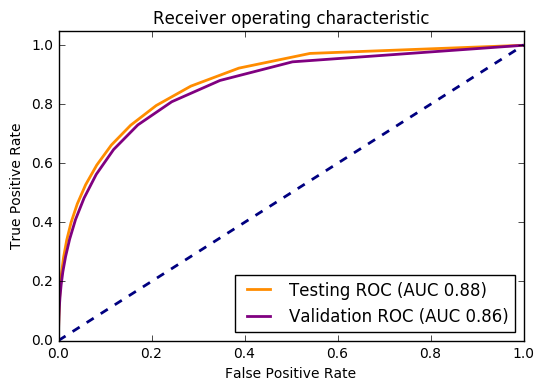

In [32]:
auc_test = auc(test_stats[:, 4], test_stats[:, 2]) #FPR,Recall
auc_val = auc(val_stats[:, 4], val_stats[:, 2])

plt.figure()
lw = 2
plt.plot(test_stats[:, 4], test_stats[:, 2], color='darkorange',lw=lw, label='Testing ROC (AUC {:.2f})'.format(auc_test))
plt.plot(val_stats[:, 4], val_stats[:, 2], color='purple', lw=lw, label='Validation ROC (AUC {:.2f})'.format(auc_val))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

#plt.savefig(fig1_name)

## Precision-Recall curve

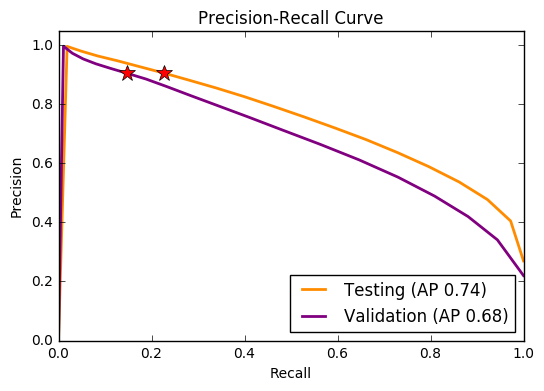

In [34]:
#find point in probability thrshold values that is closest to my image threshold (0.7)
def find_nearest1(array,value):
    idx,val = min(enumerate(array), key=lambda x: abs(x[1]-value))
    return idx

thres = 0.7


prec_t = test_stats[:, 1]
recall_t = test_stats[:, 2]
prec_v = val_stats[:, 1]
recall_v = val_stats[:, 2]

auc_t = auc(recall_t,prec_t)
auc_v = auc(recall_v,prec_v)

probs = np.linspace(1, 0, num=20)
index = find_nearest1(probs,thres)

x_thres_t = recall_t[index]
y_thres_t = prec_t[index]
x_thres_v = recall_v[index]
y_thres_v = prec_v[index]

plt.figure()
lw = 2
plt.plot(recall_t,prec_t, color='darkorange',lw=lw, label='Testing (AP {:.2f})'.format(auc_t))
plt.plot(recall_v,prec_v,  color='purple', lw=lw, label='Validation (AP {:.2f})'.format(auc_v))
plt.plot(x_thres_t, y_thres_t, color='red', lw=lw, marker='*', markersize=12) # Testing threshold tirado dos vetores prec/recall usando o index de probs mais proximos do threshold = 0.7
plt.plot(x_thres_v, y_thres_v, color='red', lw=lw, marker='*', markersize=12)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")
plt.show()

# Network Inspection: Class Activation Maps and Perturbation Tests

I use the gradient between one of the final layers and the network output to compute what are the most salient features, given a set of pre-selected output neurons, using the same concept published in https://arxiv.org/abs/1512.04150.

<img src="img/slidenet_CAM.png" width="650"/>


Create GradCAM class:

In [36]:
class GradCAM:

    def __init__(self,config_file):
        # read config
        config = cparser.RawConfigParser()
        config.read(config_file)
        path_project = config.get('data paths', 'path_project')
        path_model = os.path.join(path_project, config.get('data paths', 'path_model'))

        # dimension of the patches
        self.patch_height = int(config.get('data attributes', 'patch_height'))
        self.patch_width = int(config.get('data attributes', 'patch_width'))
        self.mask_height = int(config.get('data attributes', 'mask_height'))
        self.mask_width = int(config.get('data attributes', 'mask_width'))
        self.mask_dim = (self.mask_height, self.mask_width)
        self.imgs_to_test = int(config.get('testing settings', 'full_images_to_test')),

        # model name
        self.name_experiment = config.get('experiment name', 'name')
        self.average_mode = config.getboolean('testing settings', 'average_mode')
        self.stride_height = int(config.get('testing settings', 'stride_height'))
        self.stride_width = int(config.get('testing settings', 'stride_width'))

        # load mean image for pre-processing
        self.mean_img_path = os.path.join(path_project, config.get('data paths', 'mean_image'))

        # Load the saved model
        self.model = model_from_json(open(os.path.join(path_model, self.name_experiment + '_architecture.json')).read())
        self.model.load_weights(os.path.join(path_model, self.name_experiment + '_best_weights.h5'))


    def ind2sub(self, array_shape, ind):
        rows = (int(ind) / array_shape[1])
        cols = (int(ind) % array_shape[1])
        return (rows, cols)

    def sub2ind(self, size, r, c):
        ind = r * size[1] + c
        return ind

    # computes class activation function
    def grad_cam(self,input_model, input_data, cls, layer_name, fore_or_back=0):
        """GradCAM method for visualizing input saliency."""
        y_c = input_model.output[0, cls, fore_or_back]
        conv_output = input_model.get_layer(layer_name).output
        grads = K.gradients(y_c, conv_output)[0]
        # Normalize if necessary
        # grads = normalize(grads)
        gradient_function = K.function([input_model.input], [conv_output, grads])

        output, grads_val = gradient_function([input_data])
        output, grads_val = output[0, :], grads_val[0, :, :, :]

        output = np.transpose(output, axes=(1, 2, 0))
        grads_val = np.transpose(grads_val, axes=(1, 2, 0))

        weights = np.mean(grads_val, axis=(0, 1))
        cam = np.dot(output, weights)

        # Process CAM
        cam = cv2.resize(cam, (self.patch_width, self.patch_height), interpolation=cv2.INTER_LINEAR)
        cam = np.maximum(cam, 0)
        cam = cam / (cam.max() + 10e-20)
        return cam
    
    
    def get_data_overlap(self,orig_img):
        #prepare image
        patches_imgs_test, new_height, new_width, masks_test = get_data_segmenting_overlap(
            test_img_original=orig_img.astype('float'),
            Imgs_to_test=0,
            mean_image_path=self.mean_img_path,
            patch_height=self.patch_height,
            patch_width=self.patch_width,
            stride_height=1,
            stride_width=1,
            is_color=True
        )
        
        return patches_imgs_test, new_height, new_width, masks_test
        


    def get_mean_cam(self,mask,orig_img,layer_name, is_background):
        
        patches_imgs_test, new_height, new_width, masks_test = self.get_data_overlap(orig_img)

        # CAM
        indices = np.nonzero(mask.flatten() > 0)
        nIdx = len(indices[0])
        cams = np.zeros((self.patch_height, self.patch_width, nIdx))
        range_idx = np.arange(0, nIdx, 2)
        #is_background = 0
        for i in range_idx:
            idx_test = indices[0][i]
            r, c = self.ind2sub(mask.shape, idx_test)
            gradcam = self.grad_cam(self.model, patches_imgs_test, idx_test, layer_name, is_background)
            cams[:, :, i] = gradcam

        final_cam = np.mean(cams, axis=(2))
        final_cam = final_cam / final_cam.max()

        norm = mpl.colors.Normalize(vmin=final_cam.min(), vmax=final_cam.max())
        cmap = cm.jet
        final_cam_rgb = cmap(final_cam)  # map "colors"
        final_cam_rgb = img_as_ubyte(final_cam_rgb)
        final_cam = final_cam_rgb[:, :, 0:3]

        alpha = 0.3
        output = cv2.addWeighted(final_cam, alpha, orig_img, 1 - alpha, 0)

        return output
    
    def get_model():
        return self.model


Set files and folder names:

In [37]:
root_dir = 'gradCAM/img1/'
file_pref = 'patch_82790376-6d05-11e9-81c1-484d7ede57b2'

layer_name = 'concatenate_3'

test_file = root_dir + file_pref + '.tif'
test_file_perturb = root_dir + file_pref + '_perturb.tif'
mask_fore = root_dir + file_pref + '_mask.tif'
mask_back = root_dir + file_pref + '_back_mask.tif'
cam_file_fore = root_dir + 'cam_fore.tif'
cam_file_back = root_dir + 'cam_back.tif'
cam_file_fore_pert = root_dir + 'cam_fore_perturb.tif'
cam_file_back_pert = root_dir + 'cam_back_perturb.tif'
cam_ref_fore = root_dir + 'cam_ref_fore.tif'
cam_ref_back = root_dir + 'cam_ref_back.tif'
img_seg_file = root_dir + 'img_segmented.tif'
img_seg_file_pert = root_dir + 'img_segmented_perturb.tif'
mosaic_file = root_dir + file_pref +' _mosaic.tif'

prob_seg = root_dir + file_pref + '_prob.npy'
seg_mask_file = root_dir + file_pref + '_seg.tif'

Load test images and instatiate GradCAM:

In [38]:
#histology image
orig_img = io.imread(test_file)

#instantiate GradCAM 
grad_cam = GradCAM(config_file)

#create image mosaic, for visualization
mosaic = np.ones((408,1020,3),dtype='uint8')
mosaic[0:204,0:204,:] = orig_img[:,:,:]

/home/maryana/.local/lib/python2.7/site-packages/ipykernel/__main__.py:6: DeprecationWarning: You passed a bytestring as `filenames`. This will not work on Python 3. Use `cp.read_file()` or switch to using Unicode strings across the board.


Segment test image:

new full images shape: 
(1, 3, 204, 204)
Number of patches on h : 1
Number of patches on w : 1
number of patches per image: 1, totally for this dataset: 1


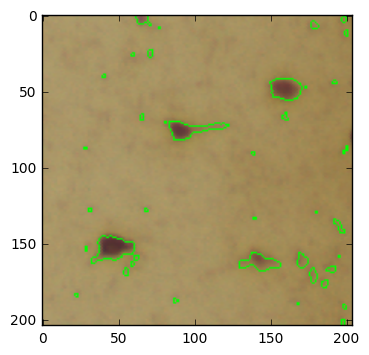

In [39]:
# Calculate predictions
patches_imgs_test, new_height, new_width, masks_test = grad_cam.get_data_overlap(orig_img)
predictions = grad_cam.model.predict(patches_imgs_test, batch_size=1, verbose=2)
pred_patches = pred_to_imgs(predictions, 200, 200, "original")
pred_patches = pred_patches[0,0,...]
pred_mask = pred_patches > 0.7
pred_mask = cv2.resize((pred_mask*255).astype('uint8'), (204, 204), interpolation=cv2.INTER_LINEAR)

# create segmentation outline
perim = bwperim(pred_mask)
seg_img = imoverlay(orig_img,perim,[0,1,0])

mosaic[0:204,204:408,:] = seg_img[:,:,:]

plt.imshow(seg_img)
plt.show()

## First, I want to use CAM to assess if the network is learning significant features:

Load foreground pixels mask and compute CAM with relation to them:

In [40]:
#load foreground mask
mask = io.imread(mask_fore)
if mask.ndim > 2:
    mask = mask[...,0]
overlay_mask = imoverlay(orig_img,mask,[1,0,0])

mosaic[0:204,408:612,:] = overlay_mask[:,:,:]
#CAM
output = grad_cam.get_mean_cam(mask,orig_img,layer_name,0)
mosaic[0:204,612:816,:] = output[:,:,:]

new full images shape: 
(1, 3, 204, 204)
Number of patches on h : 1
Number of patches on w : 1
number of patches per image: 1, totally for this dataset: 1


/home/maryana/.local/lib/python2.7/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


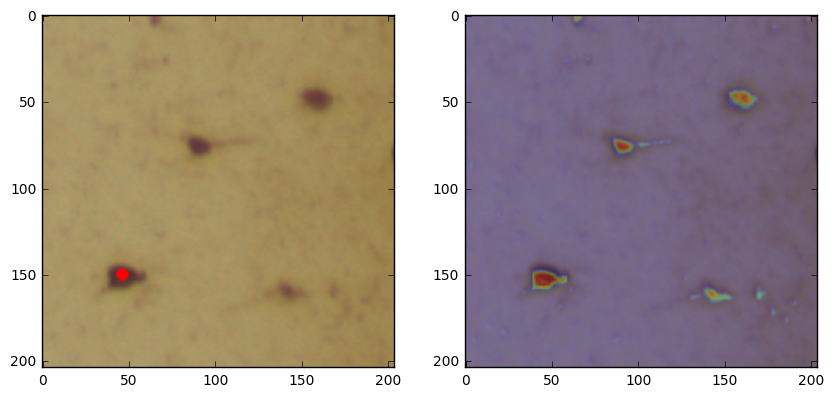

In [41]:
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(overlay_mask)
ax2 = fig.add_subplot(1,2,2)
ax2.imshow(output)
plt.show()

Load background pixels mask and compute CAM with relation to them:

In [42]:
#background mask
mask = io.imread(mask_back)
if mask.ndim > 2:
    mask = mask[...,0]
overlay_mask = imoverlay(orig_img,mask,[1,0,0])
mosaic[0:204,816:1020,:] = overlay_mask[:,:,:]

#CAM
output = grad_cam.get_mean_cam(mask,orig_img,layer_name,1)
mosaic[204:408,0:204,:] = output[:,:,:]

new full images shape: 
(1, 3, 204, 204)
Number of patches on h : 1
Number of patches on w : 1
number of patches per image: 1, totally for this dataset: 1


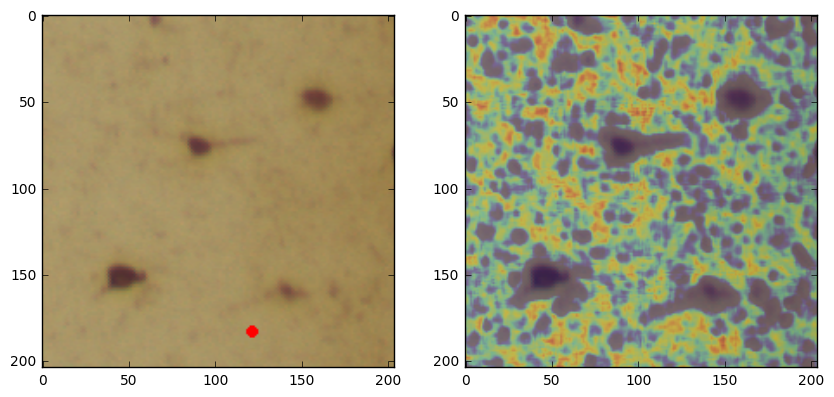

In [43]:
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(overlay_mask)
ax2 = fig.add_subplot(1,2,2)
ax2.imshow(output)
plt.show()

## Second, I manually add _perturbations_ to test images to check the network generalization.

Example of original and modified images:

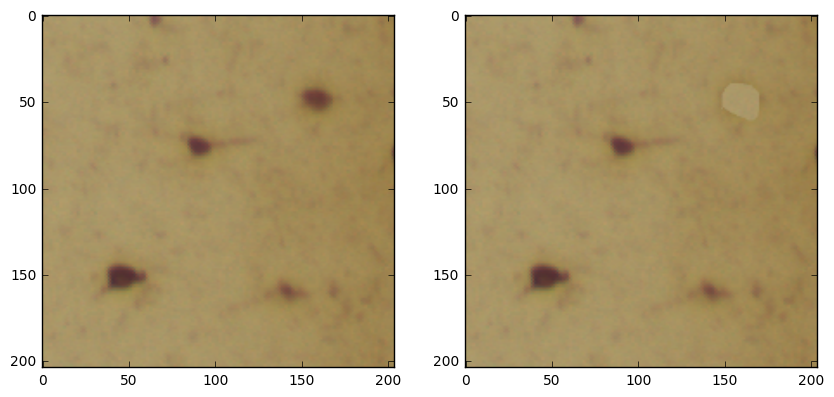

In [44]:
no_pertub = orig_img
orig_img = io.imread(test_file_perturb)
mosaic[204:408,204:408,:] = orig_img[:,:,:]

fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(no_pertub)
ax2 = fig.add_subplot(1,2,2)
ax2.imshow(orig_img)
plt.show()

Segment perturbed image:

In [45]:
# Calculate predictions
patches_imgs_test, new_height, new_width, masks_test = grad_cam.get_data_overlap(orig_img)
predictions = grad_cam.model.predict(patches_imgs_test, batch_size=1, verbose=2)
pred_patches = pred_to_imgs(predictions, 200, 200, "original")
pred_patches = pred_patches[0,0,...]
pred_mask = pred_patches > 0.7
pred_mask = cv2.resize((pred_mask*255).astype('uint8'), (204, 204), interpolation=cv2.INTER_LINEAR)

#create segmentation outline
perim = bwperim(pred_mask)
seg_img = imoverlay(orig_img,perim,[0,1,0])
mosaic[204:408,408:612,:] = seg_img[:,:,:]

new full images shape: 
(1, 3, 204, 204)
Number of patches on h : 1
Number of patches on w : 1
number of patches per image: 1, totally for this dataset: 1


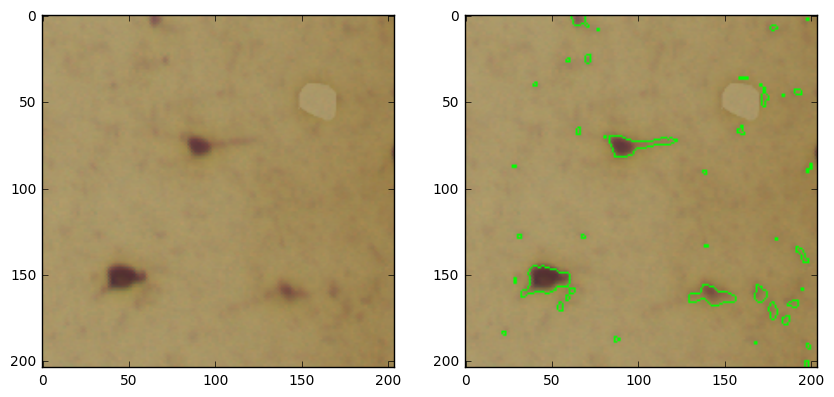

In [46]:
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(orig_img)
ax2 = fig.add_subplot(1,2,2)
ax2.imshow(seg_img)
plt.show()

Load foreground pixels mask and compute CAM with relation to them:

In [47]:
# load foreground mask
mask = io.imread(mask_fore)
if mask.ndim > 2:
    mask = mask[...,0]

#CAM
output = grad_cam.get_mean_cam(mask,orig_img,layer_name,0)
mosaic[204:408,612:816,:] = output[:,:,:]

new full images shape: 
(1, 3, 204, 204)
Number of patches on h : 1
Number of patches on w : 1
number of patches per image: 1, totally for this dataset: 1


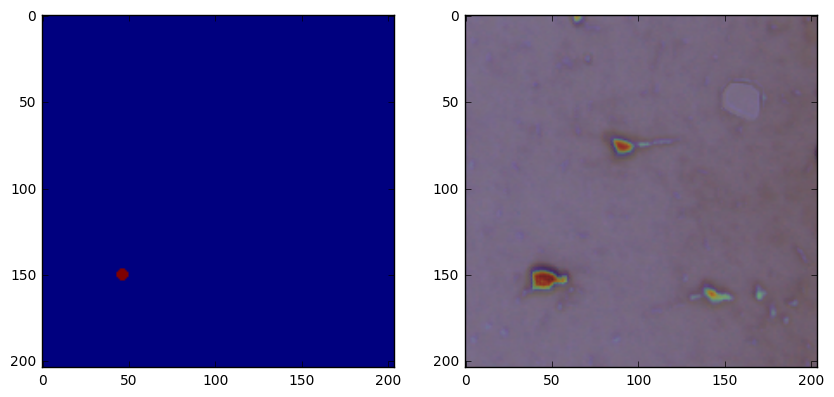

In [48]:
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(mask)
ax2 = fig.add_subplot(1,2,2)
ax2.imshow(output)
plt.show()

Load background pixels mask and compute CAM with relation to them:

In [49]:
#load background mask
mask = io.imread(mask_back)
if mask.ndim > 2:
    mask = mask[...,0]

#CAM
output = grad_cam.get_mean_cam(mask,orig_img,layer_name,1)

mosaic[204:408,816:1020,:] = output[:,:,:]

new full images shape: 
(1, 3, 204, 204)
Number of patches on h : 1
Number of patches on w : 1
number of patches per image: 1, totally for this dataset: 1


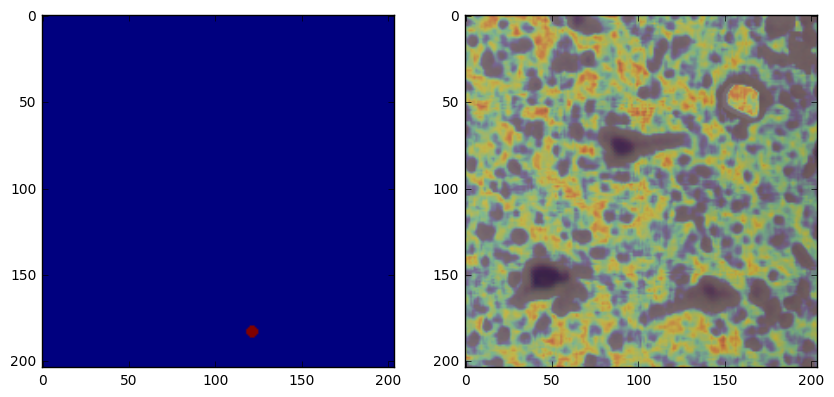

In [50]:
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(mask)
ax2 = fig.add_subplot(1,2,2)
ax2.imshow(output)
plt.show()

# What kind of results can we get from segmentation?

## Protein _Heatmap_ overlaid on other imaging modalities:

![title](img/heatmap.png)

## 3d reconstruction of a full Tau map

![title](img/AT100_3drecs.png)